In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data Preparation

In [4]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

##### There are missing values, so
##### For categorical features, replace them with 'NA'
##### For numerical features, replace with with 0.0

In [15]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [16]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [17]:
df[categorical] = df[categorical].fillna('NA')
df['annual_income'] = df['annual_income'].fillna(0.0)

##### Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [27]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [28]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance

In [26]:
from sklearn.metrics import roc_auc_score

In [84]:
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']

In [85]:
auc_scores = {}
for col in numerical:
    feature = df_train[col]
    auc = roc_auc_score(y_train,feature)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -feature)
        print(f" Inverted '{col}' because AUC was < 0.5")
    auc_scores[col] = auc
print('auc: \n', auc_scores.items())

auc: 
 dict_items([('number_of_courses_viewed', 0.7635680590007088), ('annual_income', 0.5519578313253012), ('interaction_count', 0.738270176293409), ('lead_score', 0.6144993577250176)])


### Question 2: Training the model

In [86]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [87]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [88]:
model = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, max_iter=1000, random_state = 1)
model.fit(X_train, y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [89]:
y_pred = model.predict_proba(X_val)[:, 1]

In [90]:
converted_decision = (y_pred >= 0.5)

In [91]:
y_pred.shape

(293,)

In [94]:
round(roc_auc_score(y_val,y_pred),3)

0.921

### Question 3: Precision and Recall

In [97]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, precision, recall))

/tmp/ipykernel_3116/3297862606.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [98]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [99]:
df_scores

,threshold,precision,recall
0,0.00,0.583618,1.000000
1,0.01,0.595819,1.000000
2,0.02,0.606383,1.000000
3,0.03,0.612903,1.000000
4,0.04,0.615942,0.994152
...,...,...,...
96,0.96,0.984375,0.368421
97,0.97,1.000000,0.345029
98,0.98,1.000000,0.274854
99,0.99,1.000000,0.228070


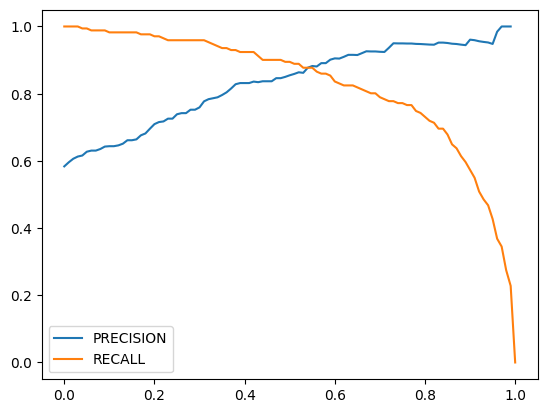

In [102]:
plt.plot(df_scores.threshold, df_scores['precision'], label='PRECISION')
plt.plot(df_scores.threshold, df_scores['recall'], label='RECALL')
plt.legend()

In [103]:
df_scores['diff'] = abs(df_scores['precision'] - df_scores['recall'])
intersection_row = df_scores.loc[df_scores['diff'].idxmin()]

In [104]:
intersection_row

threshold    0.540000
precision    0.877193
recall       0.877193
diff         0.000000
Name: 54, dtype: float64

### Question 4: F1 score

In [105]:
df_scores['F1_score'] = 2 * ((df_scores['precision'] * df_scores['recall'])/(df_scores['precision'] + df_scores['recall']))

In [106]:
df_scores

,threshold,precision,recall,diff,F1_score
0,0.00,0.583618,1.000000,0.416382,0.737069
1,0.01,0.595819,1.000000,0.404181,0.746725
2,0.02,0.606383,1.000000,0.393617,0.754967
3,0.03,0.612903,1.000000,0.387097,0.760000
4,0.04,0.615942,0.994152,0.378210,0.760626
...,...,...,...,...,...
96,0.96,0.984375,0.368421,0.615954,0.536170
97,0.97,1.000000,0.345029,0.654971,0.513043
98,0.98,1.000000,0.274854,0.725146,0.431193
99,0.99,1.000000,0.228070,0.771930,0.371429


In [107]:
max_f1_score = df_scores.loc[df_scores['F1_score'].idxmax()]
max_f1_score

threshold    0.550000
precision    0.882353
recall       0.877193
diff         0.005160
F1_score     0.879765
Name: 55, dtype: float64

### Question 5: 5-Fold CV

In [139]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C = 1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [140]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [141]:
from sklearn.model_selection import KFold

In [142]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted
    y_val = df_val.converted

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print(scores)
    print('%.4f' % (np.std(scores)))

[0.8060745924216483]
0.0000
[0.8060745924216483, 0.8713738368910783]
0.0326
[0.8060745924216483, 0.8713738368910783, 0.7754320118852139]
0.0400
[0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685]
0.0353
[0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
0.0358


### Question 6: Hyperparameter Tuning

In [146]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted
        y_val = df_val.converted

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.822 +- 0.036
C=0.001 0.822 +- 0.036
C=1 0.822 +- 0.036
